# Project 4

## Random walking dead


## Group 1 9:

- Mussa Banjai
- Tapas Dev
- Jason Kapka
- Taz Ahmed

## Introduction



This study introduces an agent-based model to simulate the spread of a contagious disease in isolated populations through a 2D random walk, emphasizing randomness in the simulation. The population consists of individuals with distinct disease states (susceptible, infectious, and dead) represented on a lattice. The model integrates random movements, disease transmission, and death probabilities. The simulation is performed using a Monte Carlo approach, enabling the study of disease dynamics at the individual level.

The simulator is implemented as a Python class, facilitating multiple runs and data collection. The class includes methods for updating walker positions, checking legality of moves, and handling interactions between humans and zombies. The study explores scenarios with a single initial zombie, investigating the fate of the populations over time.

Additionally, the model is compared with an ODE-based deterministic SZ-model, highlighting the differences and potential insights gained from both approaches. A key focus is on estimating the effective contact rate from the random walk simulations and applying it to the ODE model for comparison.

The study concludes with a real-world scenario involving two villages and their responses to a zombie outbreak, introducing variations in zombie lifespans and population behavior. Overall, this work provides a flexible tool for simulating disease spread in different settings and offers insights into the interplay between randomness and deterministic modeling.

## Abstract



In this project several models are built to simulate the spread of a highly contagious zombie-inducing disease through a finite and isolated population. The main benefits of the agent-based model are that it can closely represent the interaction or collision between healthy humans and sick zombies which allows the disease to spread, while the main drawback is the processing time required depending on the coding method utilized. The main benefits of the classical ODE model is the very fast calculation time to model how a population transitions from being healthy to diseased, while the main drawback is how sensitive the results are to the beta factor which dictates how closely is can represent a random-walk simulation. 


## Libraries

In [2]:
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import math as m
import scipy as sp
from scipy import optimize
import pandas as pd
import scipy.integrate

from enum import Enum # Importing the enum

## Directions

In [3]:
class Direction(Enum):

    EAST = 1
    NORTH = 2
    WEST = 3
    SOUTH = 4

## Disease State

In [4]:
class DiseaseState(Enum):

    HUMAN = 0 # SUSCEPTIBLE = HUMAN
    EXPOSED = 1
    ZOMBIE = 2 #INFECTIOUS = ZOMBIE
    IMMUNE = 3
    DEAD = 4

## Random Walk Epidemic Simulator class

In [5]:
class RandomWalkEpidemicSimulator:
    """
    Class used to model the spreading of a contagious disease in a
    population of individuals with a 2D random walk.

    Each walker has a disease state which is represented by an
    integer Enum. Also, a set of integer (x, y)-coordinates are
    stored for each walker. The possible coordinates are:

        {0, 1, ..., Lx-1} in the x-direction
        {0, 1, ..., Ly-1} in the y-direction

    It is only possible to move North, South, East, or West. If a
    walker attempts to move outside of the physical domain, nothing
    happens (i.e., a "bounce-back boundary condition" is enforced).
    """
    def __init__(self,
                 population_size,
                 no_initially_infected=1,
                 nx=50,
                 ny=50,
                 q=0.9,
                 p = 0.0,
                 gameshow=False):
        """
        :param population_size: The total number of people (N).
        :param no_init_infected: The number of infected people at t=0.
        :param nx: The number of lattice nodes in the x-direction
        :param ny: The number of lattice nodes in the y-direction.
        :param q: The probability of infection (0 <= q <= 1).
        :param p: The probability of death (0 <= p <= 1).
        :gameshow: It enables/disables the graph of the walkers.
        """
        self.N_ = population_size
        self.Z0_= no_initially_infected # No. of Zombies that are starting
        self.nx_= nx
        self.ny_= ny
        self.infection_probability_ = q
        self.death_probability_ = p
        self.gameshow = gameshow


        self.Walkers_ = np.random.randint(0, [self.nx_, self.ny_], size=(self.N_, 2))
        self.Walkers_Old_ = self.Walkers_.copy() # in case any move is illegall, we have a old steps

        # First, let all walkers be in the susceptible compartment:
        self.State_ = np.full(self.N_, DiseaseState.HUMAN.value)
        # Next, change walker number 0, 1, 2, ..., I0-1 to be infectious:
        self.State_[0:self.Z0_] = DiseaseState.ZOMBIE.value

        # Records
        self.record_humans = np.array([])
        self.record_zombies = np.array([])
        self.record_deads = np.array([])

        

    def move(self):
        """
        This function allows the walkers to change their position
        """
        
        proposed_directions=np.random.randint(0,4,size=self.N_) #The directions will be choosen randomly for all the walkers.
        
        # Directions
        move_east = (proposed_directions == Direction.EAST.value)
        move_north = (proposed_directions == Direction.NORTH.value)
        move_west = (proposed_directions == Direction.WEST.value)
        move_south = (proposed_directions == Direction.SOUTH.value)

        # This will only allow Walkers that are not dead to walk
        not_dead = (self.State_ != DiseaseState.DEAD.value)


        self.Walkers_[move_east & not_dead] += [1, 0]
        self.Walkers_[move_north & not_dead] += [0, 1]
        self.Walkers_[move_west & not_dead] -= [1, 0]
        self.Walkers_[move_south & not_dead] -= [0, 1]





    def is_at_illegal_position(self):
        """
        Checks if it is out of position
        """
        wrong_x=np.logical_or(self.Walkers_[:,0]<0,self.Walkers_[:,0]>=self.nx_)
        wrong_y=np.logical_or(self.Walkers_[:,1]<0,self.Walkers_[:,1]>=self.ny_)
        wrong_xy=np.logical_or(wrong_x,wrong_y)
        self.Walkers_[wrong_xy]=self.Walkers_Old_[wrong_xy]
        
        self.Walkers_Old_=np.copy(self.Walkers_)

    

    def collide_extremely_slowly(self): # note: class (instance) function
        '''
        Note: SUSCEPTIBLE = HUMAN, and INFECTIOUS = ZOMBIE
        This code is so slow that it will be impractical to use in the full project.
        You can use it to test your code. HINT: Try to use np.logical_and to find humans
        at	the same place as zombies, instead of the loop: for walker_idx in range(self.N_):
        '''

        # Get (x,y)-coordinates of susceptibles & infectious people
        S_coord = self.Walkers_[self.State_== DiseaseState.HUMAN.value]
        I_coord = self.Walkers_[self.State_ == DiseaseState.ZOMBIE.value]

        no_infected = len(I_coord)
        for infected_idx in range(no_infected):
            for walker_idx in range(self.N_):
                walker_is_susceptible = (self.State_[walker_idx] == DiseaseState.HUMAN.value)
                infected_at_same_location = np.all(I_coord[infected_idx] == self.Walkers_[walker_idx])
                
                if walker_is_susceptible and infected_at_same_location:
                    q = np.random.uniform(0, 1)
                    if q < self.infection_probability_:
                        self.State_[walker_idx] = DiseaseState.ZOMBIE.value

    def collide_much_much_faster(self):
        '''
        Calculates interaction between Zombies and Walkers (class implementation)
        '''
        Z_coord = self.Walkers_[self.State_ == DiseaseState.ZOMBIE.value]
        for infected_idx in Z_coord: # loop over all zombies
            # compare x and y coordinate of one zombie and all Walkers to
            # find which are in the same place
            infected_at_same_location_xy = np.logical_and(infected_idx[0]==self.Walkers_[:,0],infected_idx[1]==self.Walkers_[:,1])
            
            # infected_at_same_location_xy contains a list of True/False of all
            # Walkers at the same/not the same place (both Humans and Zombies)
            # get the index to the Walkers, needed to update state (note the [0] at the end)
            id_walkers_at_same_location = np.where(infected_at_same_location_xy)[0]
            for walkers_id in id_walkers_at_same_location:
                if self.State_[walkers_id] == DiseaseState.HUMAN.value:
                    q = np.random.uniform(0, 1)
                    if q < self.infection_probability_:
                        self.State_[walkers_id] = DiseaseState.ZOMBIE.value

    def check_if_zombies_dies(self):

        # Find the index of the Zombies
        # Loop through it 
        zombies_idx = np.where(self.State_ == DiseaseState.ZOMBIE.value)
        for idx in zombies_idx: # loop over all zombies
                p = np.random.uniform(0, 1)
                if p < self.death_probability_:
                    self.State_[idx] = DiseaseState.DEAD.value

                

    def game(self):
        Z_coord= self.Walkers_[self.State_== DiseaseState.ZOMBIE.value]
        H_coord= self.Walkers_[self.State_==DiseaseState.HUMAN.value]
        D_coord = self.Walkers_[self.State_==DiseaseState.DEAD.value]
        plt.scatter(Z_coord[:,0],Z_coord[:,1],s=80,c='r')
        plt.scatter(H_coord[:,0],H_coord[:,1],c='b')
        plt.scatter(D_coord[:,0],D_coord[:,1], marker='s', c='y')
        plt.xlim(0,self.nx_)
        plt.ylim(0,self.ny_)
        plt.grid()
        plt.show()

    def record(self):
        no_susceptible = np.sum(self.State_ == DiseaseState.HUMAN.value)
        no_infectious = np.sum(self.State_ == DiseaseState.ZOMBIE.value)
        no_recovered = np.sum(self.State_ == DiseaseState.DEAD.value)

        self.record_humans = np.append(self.record_humans, no_susceptible)
        self.record_zombies = np.append(self.record_zombies, no_infectious)
        self.record_deads = np.append(self.record_deads, no_recovered)
        

    
    def run(self, steps):
        for s in range(steps):
            if self.gameshow == True:
                self.game()
            self.record()
            self.move()
            self.is_at_illegal_position()
            self.collide_much_much_faster()
            self.check_if_zombies_dies()


    def stats(self):
        """
        It shows the statistics of humans, zombies and deaths
        """
        new_line = "\n"

        no_susceptible = np.sum(self.State_ == DiseaseState.HUMAN.value)
        no_infectious = np.sum(self.State_ == DiseaseState.ZOMBIE.value)
        no_recovered = np.sum(self.State_ == DiseaseState.DEAD.value)

        print(f"Susceptibles: {no_susceptible}{new_line}Infectious: {no_infectious}{new_line}Recovered: {no_recovered}")

## Exercises

### Exercise 1: Random walk SZ-model

Check the class

In [6]:
def record_humans_zombies_deads(simulations, timesteps, z_init, p = 0.0, N = 683):
    Record_Array_Humans = []
    Record_Array_Zombies = []
    Record_Array_Deads = []

    for n in range(simulations): # run n simulations
        r683 = RandomWalkEpidemicSimulator(N, z_init, 50, 50, 0.9, p)
        r683.run(timesteps)
        Record_Array_Humans.append(r683.record_humans)
        Record_Array_Zombies.append(r683.record_zombies)
        Record_Array_Deads.append(r683.record_deads)
    Record_Array_Humans = np.array(Record_Array_Humans)
    Record_Array_Zombies = np.array(Record_Array_Zombies)
    Record_Array_Deads = np.array(Record_Array_Deads)

    return Record_Array_Humans, Record_Array_Zombies, Record_Array_Deads

In [7]:
def plot_humans_zombies(record_humans, record_zombies):
    hx = np.arange(np.shape(record_humans)[1])
    hmean = np.mean(record_humans, 0) # Mean
    hstd = np.std(record_humans, 0) # Standard Deviation

    zx = np.arange(np.shape(record_zombies)[1])
    zmean = np.mean(record_zombies, 0) # Mean
    zstd = np.std(record_zombies, 0) # Standard Deviation

    plt.title(f"")

    plt.plot(hx, hmean, color = "blue", linestyle = "--", label = "Susceptible - RW") # plot the mean
    plt.fill_between(hx, hmean - hstd, hmean + hstd, color='grey', alpha=0.5)

    plt.plot(zx, zmean, color = "red", linestyle = "--", label = "Infected - RW") # plot the mean
    plt.fill_between(zx, zmean - zstd, zmean + zstd, color='grey', alpha=0.5)

    plt.legend()
    plt.grid()

#### Question 1


In [8]:
h, z, r = record_humans_zombies_deads(100, 300, 1)

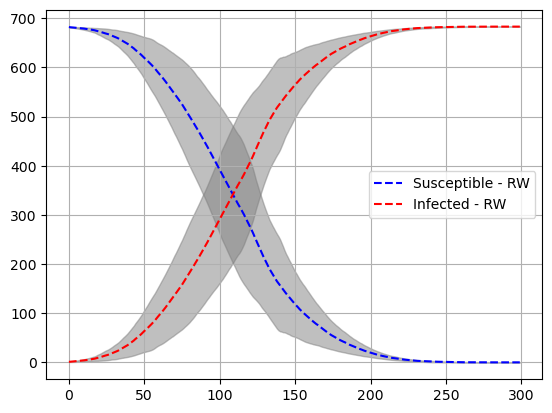

In [9]:
plot_humans_zombies(h, z)

**Answer:**

The fate of the zombie and human population for the Z(0)= 1 simulation goes as follows:
- In the initial phase there are fewer human-to-zombie conversions since there are so few zombies relative to the grid size, but the rate of conversions is increasing.
- At about timestep 110 (on average) there are equal numbers of zombies and humans, and this is when the rate of conversion is maximized as shown by the constant positive slope of infected people on the walker vs timestep graph. This result is intuitive since one would expect to have the greatest number of conversions when there were similar numbers of zombies and humans colliding.
  - Note: in the assignment handout the intersection point of humans and zombies occurs at about timestep 160-170 (on average), and at the point it is not known if the discrepancy is due to a deviation in our code.
- In the final phase there are fewer human-to-zombie conversions since there are so few humans remaining, and the rate of conversions is decreasing, and finally drops off to zero around timestep 250 when there are zero humans remaining.
  - Note: in the assignment handout at around timestep 300 there are zero humans remaining, indicating that further investigations are required into our code and the code used to generate the project handout. 


#### Question 2


In [10]:
h10, z10, r10 = record_humans_zombies_deads(100, 300, 10)

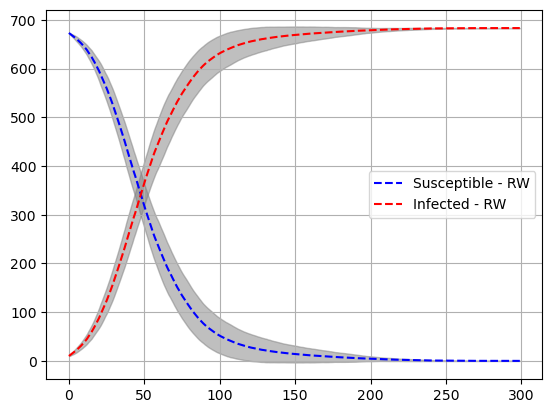

In [11]:
plot_humans_zombies(h10, z10)

**Answer:**

The fate of the zombie and human population for the alternative scenario where Z(0)= 10 simulation goes as follows:
  - In the initial phase the rate of human-to-zombie conversion increases very rapidly and is nearly maximized by about timestep 25 (on average).
  - At about timestep 50 (on average) there are equal numbers of zombies and humans. This result is intuitive since one would expect to convert half the humans to zombies much faster when starting out with ten initial zombies versus just one. Visually, the maximum rate appears to be 10 human-to-zombie conversions per timestep, which is greater than the value of 6 in the previous example. This result is counter-intuitive for me since I would have expected the maximum conversion rate to be same regardless of how many zombies existed at timestep zero (up-to a maximum of 50/50 humans and zombies) and indicates that additional investigation is warranted.
  - In the final phase there are fewer human-to-zombie conversions since there are so few humans remaining like in the previous example with one initial zombie; however, we reach this zero conversion drop-off point at around timestep 225 when there are zero humans remaining, which is sooner than in the previous example as expected (but perhaps not soon enough).

### Exercise 2: Compare random walk and ODE-based models

In [16]:
class ODE:
    def __init__(
            self,
            N,
            Z_init,
            Sn,
            Zn,
            Rn,
            time = 300
            ):

        self.time = np.arange(time)

        self.N = N
        self.Z_init = Z_init

        self.Zn = Zn[:, 1:]

        self.Sn = Sn[:, 1:]
        self.Sn_1 = Sn[:, :-1]

        self.Rn = Rn[:, 1:]
        self.Rn_1 = Rn[:, :-1]

        self.beta = - ((self.Sn - self.Sn_1)*self.N) / ((self.Sn+1)*self.Zn)
        self.betamedian = np.median(self.beta) # median for the beta
        self.betamean = np.mean(self.beta) # mean for the beta

        self.betterbetamean = np.mean(self.beta[:, 0:np.shape(np.mean(Sn,0)[np.mean(Sn,0) > np.mean(Sn,0)[0] * 0.25])[0]]) # better mean for the beta using first 75% of human-zombie conversions

        self.tau = (self.Rn - self.Rn_1)/(self.Zn)
        self.taumean = np.mean(self.tau) # mean for the tau


    def Z(self, t):
        S0 = self.N - self.Z_init
        Z0 = self.Z_init

        return self.N / (1 + (S0/Z0) * np.exp(-self.betamean * t))

    def betterZ(self, t):
        S0 = self.N - self.Z_init
        Z0 = self.Z_init

        return self.N / (1 + (S0/Z0) * np.exp(-self.betterbetamean * t))

    def dR(self, t):
        return (1/self.taumean + 1) * self.Z(t)

    def plot(self):
        plt.plot(self.time, self.Z(self.time), label = f"Zombies - ODE w beta {round(self.betamean, 4)}")
        plt.plot(self.time, self.betterZ(self.time), label = f"Zombies - ODE w better beta {round(self.betterbetamean, 4)}")

    def plot_R(self):
        plt.plot(self.time, self.dR(self.time), label = "Dead - ODE")

    def return_beta(self):
        return self.beta 


#### Question 1

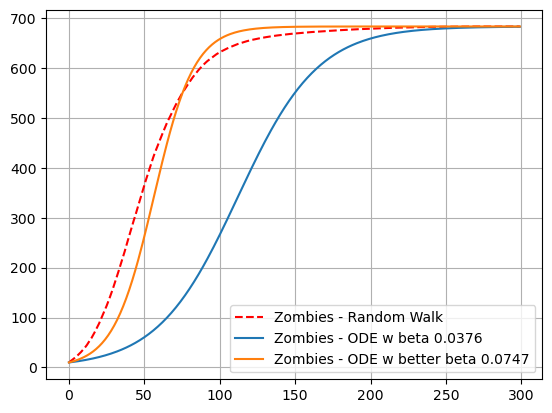

In [17]:
zx_10 = np.arange(np.shape(z10)[1])
zmean_10 = np.mean(z10, 0) # Mean

ode = ODE(683, 10, h10, z10, r10)
plt.plot(zx_10, zmean_10, color = "red", linestyle = "--", label = "Zombies - Random Walk") # plot the random walk
ode.plot() # plot the analytical
plt.legend()
plt.grid()


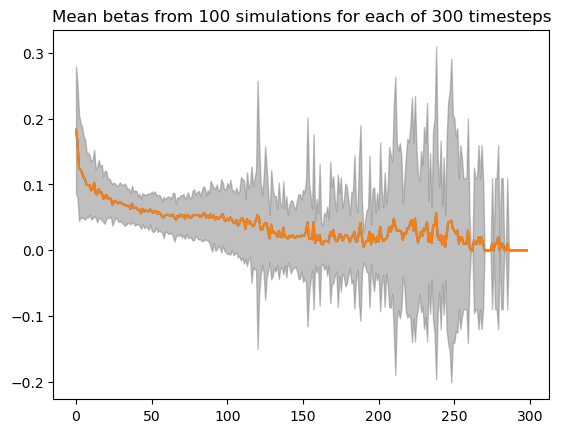

In [18]:
np.shape(ode.return_beta())
np.mean(ode.return_beta(), 0)
np.shape(np.mean(ode.return_beta(),0))[0]
plt.plot(
    np.arange(np.shape(np.mean(ode.return_beta(),0))[0]),
    np.mean(ode.return_beta(), 0),
    )
plt.title("Mean betas from 100 simulations for each of 300 timesteps")
np.mean(ode.return_beta(), 0)
np.std(ode.return_beta(), 0)
plt.plot(
    np.arange(np.shape(np.mean(ode.return_beta(),0))[0]),
    np.mean(ode.return_beta(), 0),
    )
plt.title("Mean betas from 100 simulations for each of 300 timesteps")

plt.fill_between(
    np.arange(np.shape(np.mean(ode.return_beta(),0))[0]), 
    np.mean(ode.return_beta(), 0) - np.std(ode.return_beta(), 0),
    np.mean(ode.return_beta(), 0) + np.std(ode.return_beta(), 0),
    color='grey',
    alpha=0.5
    )

**Answer:**

A comparison between our Monte Carlo random walk prediction and the continuum ODE model is shown in the figure. The beta is estimated by taking the average of the 300 time-steps of the 100 simulations. The resultant beta value was ~0.0375; however, the ODE model with this value does not closely match our random walk model.

Part of the discrepancy between the models can be explained by the fact that when there are no humans left to convert into zombies, which occurs around timestep 225/250 for the 1/10 initial zombie simulations, then the beta value for all subsequent timesteps goes to zero. If we include the timesteps with one or more human remaining, then we can get a less unbiased beta estimate of ~0.045. Inspecting the individual betas for the 300 timesteps of one 10-zombie simulation iteration, we can see the variability of their values, especially above timestep 100.

 

We considered that by only using the betas for when the first 75% of humans are converted into zombies would give an even less biased beta estimate of about 0.07 to 0.08, which results in a much closer fit between the ODE and random walk models for the 10-zombie case.

Note: additional coding is still required in order to capture this beta estimate cut-off concept into the program as the plot below was done in spaghetti code in an offline fork of the program and not re-incorporated into the main branch. Additional investigation is also required to see if the 75% cutoff also applies for the 1-zombie simulations and other parameter initializations.

### Exercise 3: Scenario what happens in Sokndal and Dirdal?

Check the class

In [51]:
def plot_humans_zombies_deads(record_humans, record_zombies, record_deads):
    hx = np.arange(np.shape(record_humans)[1])
    hmean = np.mean(record_humans, 0) # Mean
    hstd = np.std(record_humans, 0) # Standard Deviation

    zx = np.arange(np.shape(record_zombies)[1])
    zmean = np.mean(record_zombies, 0) # Mean
    zstd = np.std(record_zombies, 0) # Standard Deviation

    rx = np.arange(np.shape(record_deads)[1])
    rmean = np.mean(record_deads, 0) # Mean
    rstd = np.std(record_deads, 0) # Standard Deviation

    

    plt.plot(hx, hmean, color = "blue", linestyle = "--", label = "Susceptible - RW") # plot the mean
    plt.fill_between(hx, hmean - hstd, hmean + hstd, color='grey', alpha=0.5)

    plt.plot(zx, zmean, color = "red", linestyle = "--", label = "Infected - RW") # plot the mean
    plt.fill_between(zx, zmean - zstd, zmean + zstd, color='grey', alpha=0.5)
    
    plt.plot(rx, rmean, color = "green", linestyle = "--", label = "Recovered - RW") # plot the mean
    plt.fill_between(rx, rmean - rstd, rmean + rstd, color='grey', alpha=0.5)


**Sokndal**

In [63]:
h1s, z1s, d1s = record_humans_zombies_deads(100, 300, 10, p=1/24)

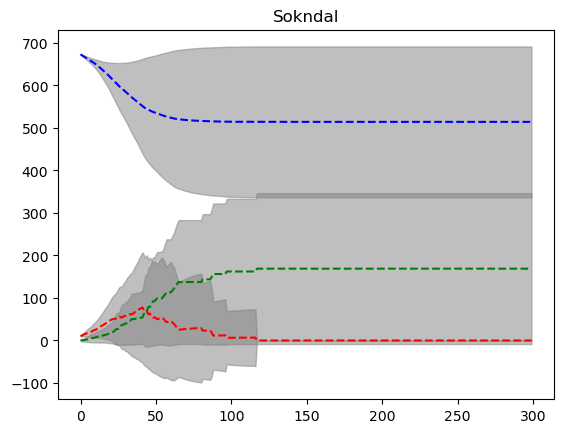

In [64]:
plt.title("Sokndal")
plot_humans_zombies_deads(h1s, z1s, d1s)

In [55]:
sokndal = RandomWalkEpidemicSimulator(683, 10, p=1/24)
sokndal.run(300)
sokndal.stats()

Susceptibles: 632
Infectious: 0
Recovered: 51


**Dirdal**

In [62]:
h1d, z1d, d1d = record_humans_zombies_deads(100, 300, 10, p=1/48)

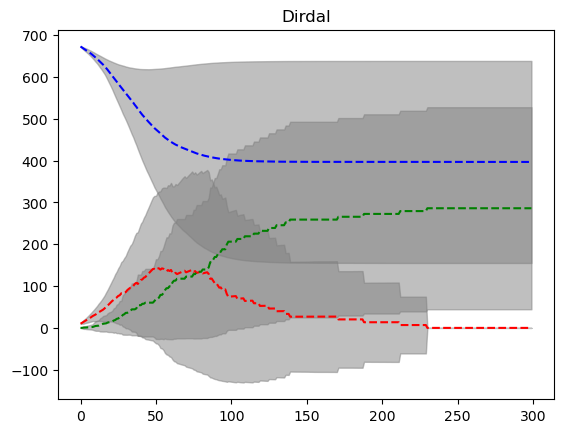

In [65]:
plt.title("Dirdal")
plot_humans_zombies_deads(h1d, z1d, d1d)

In [26]:
dirdal = RandomWalkEpidemicSimulator(683, 10, p=1/48)
dirdal.run(48)
dirdal.stats()

Susceptibles: 637
Infectious: 0
Recovered: 46


#### Question 1

**Answer:**

Assuming we run the same amount of hours, the number of zombies decreases quicker in Sokndal than in Dirdal. Which means, the humans survive more in Sokndal than in Dirdal

#### Question 2


**Answer:**

**Comment**

While expanding and testing the model for the Sokndal and Dirdal scenarios where the zombies have finite life expectancies, some issues arose when it was observed than all of the zombies would die off at the same time, which was not as intended. Addition work remains in order to get this simulation operational and then make the comparison with the SZR model.

### Exercise 4: Compare your results with SZR model

In [22]:
h4, z4, r4 = record_humans_zombies_deads(100, 1000, 1, 0.001)

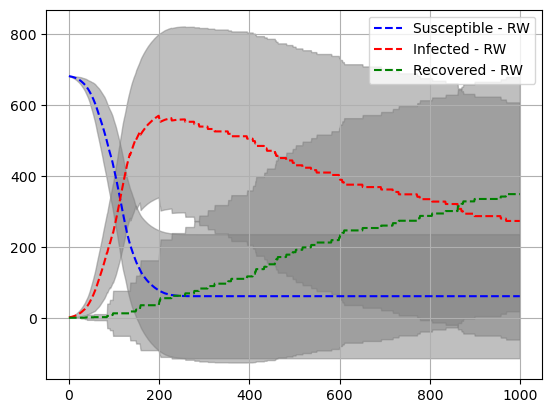

In [23]:
plot_humans_zombies_deads(h4, z4, r4)
plt.legend()
plt.grid()

### Exercise 5: Implement your own scenario

We decided to create a diferent file that will be dedicated to the own scenario. This decision was made because it does not affect the original Random Walk Class.
[Random Walk Dead - Own Scenario](RWD.ipynb)

## Reflections

### How did we work?
Basically, we worked on project in the group room, alongside with the lab classes which helped us a lot to discuss about the problems as well as finding the solution. We worked together even if any of us find any solution then we discussed about this and then came to a proper solution which looked like a good way of learning for us. Before finalizing any problem's solution, we together ended up with a good solution and agreed upon that.

Mussa wrote large sections of Python code and acted as Project Manager by compiling the individual contributions into a final product. Jason created some iplottings and extra solutions and worked on finding the solutions to the problem in theoretical matter. Taz and Tapas worked also on the theorectical matter proofs final Python code. 


### What we did in the project?
We created two classes: Random Walk Simulator and an ODE. We also created som enumerators for direction and Diease states, where it makes easier to read and apply when coding. In the end, we expanded the Random Walk Simulator by adding extra roles and attributes and creating some scenarios.

### Our Learnings?
We learnt the implementation of Monte Carlo solvers for the Random Walk Simulation. Besides, we also came across the learning of comparing different scenarios of the infactions. This project also allowed us to be creative. Although we did struggle in some stages but this project will help us in near future.

## Conclusion

This project demonstrated some of the differences between finely focused agent-based models, such as Monte Carlo random-walk, and coarser classical compartment techniques, such as ordinary differential equations (ODEs) models. The models in this project were designed and built to represent how a zombie-inducing disease could be spread through a finite and location-constrained population. The method of transmission for the disease if through physical contact caused by random collisions at discrete timesteps between humans and zombies on a grid layout. The collision-based models built here are not limited to disease transmission and could be readily adapted to represent the spread of information/rumors [C1] or nuclear chain reactions [C2].

When implementing classical ODE equations to try to mimic the random walk MC model, we found then selecting an unbiased beta was crucial, since the average beta value is dragged lower if using zero-value timesteps after there are no humans remaining. We implemented a method to only average the betas from the timesteps until less than 25% of the human population remains, at which point the standard deviation of betas increases greatly.

We also got some reflections on how it would affect the whole dynamic when adding different roles/states.

## References

1) Aksel Hiorth. Computational Engineering and Modeling, 2021
   https://github.com/ahiorth/CompEngineering
   
2) Wikipedia. Compartmental models in epidemiology
   https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology

3) Jake VanderPlas. Python Data Science Handbook
   https://jakevdp.github.io/PythonDataScienceHandbook/02.06-boolean-arrays-and-masks.html

4) Real Python. Shallow vs Deep Copying of Python Objects
   https://realpython.com/copying-python-objects/

5) ScienceDirect. A random walk Monte Carlo simulation study of COVID-19-like infection spread
   https://www.sciencedirect.com/science/article/pii/S0378437121002867

6) [C1] Draief M, Ganesh A. A random walk model for infection on graphs: spread of epidemics & rumours with mobile agents. Discrete Event Dyn Syst. 2011;21(1):41-61. doi: 10.1007/s10626-010-0092-5. Epub 2010 Aug 17. PMID: 32214674; PMCID: PMC7088300.

7) [C2] Nuclear fission and fusion in a random-walk model, M. Albertsson (Lund U.), e-Print: 2207.04919 [nucl-th].